In [1]:
# Importing the libraries
import configparser
import tweepy
import pandas as pd
import re
import emoji
import numpy as np

In [2]:
# Read the config file
config = configparser.ConfigParser()
config.read('twitterconfig.ini')

# Read the values
api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [3]:
# Authenticate
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [4]:
search_term = 'Summer'
limit = 100

# Search using pagination
tweets = tweepy.Cursor(api.search_tweets,  q= search_term + "-filter:retweets", lang = "en", tweet_mode = "extended").items(limit)

# Create columns for the DataFrame
columns = ['Time', 'User', "Likes",'Tweet']
data = []

# Iterate through the results and append them to the list
for tweet in tweets:
    data.append([tweet.created_at, tweet.user.screen_name, tweet.favorite_count, tweet.full_text])

# Create a dataframe with the results
df = pd.DataFrame(data, columns=columns)


In [5]:
df.head()

,Time,User,Likes,Tweet
0,2023-06-14 07:14:05+00:00,washi59456,0,King's Hawaiian Aloha All Summer Sweepstakes h...
1,2023-06-14 07:14:04+00:00,RobinBaird_,0,gmgm! \n\nStill going back through recent film...
2,2023-06-14 07:14:03+00:00,liyahhbabiii,0,@whitezsister havin them turnt around gives ‘u...
3,2023-06-14 07:14:03+00:00,AishatuGwadabe,0,Euphoric to announce my selection as a @Hursto...
4,2023-06-14 07:14:03+00:00,_barbiebitchx,0,Thought that hayfever skipped me this summer. ...


In [6]:
#clean the text
def cleantext(text):

   
    text = re.sub(r"@[A-Za-z0-9]+", "", text) #remove @mentioned
    text = re.sub(r"#", "", text) #remove # symbol
    text = re.sub(r"https:\/\/S+", "", text) #remove hyper link
    text = text.replace('\r', '').replace('\n', '').replace('\n', '').replace("&amp;", '').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'[^\w\s]', '', text)
    return text

df["Tweet"] = df["Tweet"].apply(cleantext)

In [7]:
#remove dublicate tweets
df_dup = df[df['Tweet'].duplicated()]
text_arr = np.unique(df_dup['Tweet'].values)
df_dup = df[df['Tweet'].isin(text_arr)].sort_values(by=['Tweet'])
df_dup_contradiction = df_dup[df_dup['Tweet'].duplicated()]
df_dedup = df.drop_duplicates(subset=['Tweet'])
df_dedup = df_dedup[~df_dedup['Tweet'].isin(df_dup_contradiction['Tweet'].values)]

In [8]:
df_dedup.head()

,Time,User,Likes,Tweet
0,2023-06-14 07:14:05+00:00,washi59456,0,kings hawaiian aloha all summer sweepstakes
1,2023-06-14 07:14:04+00:00,RobinBaird_,0,gmgm still going back through recent film scan...
2,2023-06-14 07:14:03+00:00,liyahhbabiii,0,havin them turnt around gives using my kids a...
3,2023-06-14 07:14:03+00:00,AishatuGwadabe,0,euphoric to announce my selection as a summer...
4,2023-06-14 07:14:03+00:00,_barbiebitchx,0,thought that hayfever skipped me this summer w...


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
from scipy.special import softmax

In [10]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(roberta)

In [12]:
def sentiment_score(Tweet):
    encoded_tweet = tokenizer(Tweet, return_tensors="pt")
    output = model(**encoded_tweet)
    scores = output[0][0].detach().numpy()

    scores = softmax(scores)
    
    return scores

In [13]:
df_dedup["sentiment_scores"] = df_dedup["Tweet"].apply(lambda x:(sentiment_score(x)))

In [14]:
df_dedup["sentiment"] = df_dedup["Tweet"].apply(lambda x:np.argmax(sentiment_score(x)))

In [15]:
df_dedup.head()

,Time,User,Likes,Tweet,sentiment_scores,sentiment
0,2023-06-14 07:14:05+00:00,washi59456,0,kings hawaiian aloha all summer sweepstakes,"[0.034960084, 0.90546227, 0.059577715]",1
1,2023-06-14 07:14:04+00:00,RobinBaird_,0,gmgm still going back through recent film scan...,"[0.0019046804, 0.03845691, 0.9596384]",2
2,2023-06-14 07:14:03+00:00,liyahhbabiii,0,havin them turnt around gives using my kids a...,"[0.34922332, 0.5675332, 0.08324358]",1
3,2023-06-14 07:14:03+00:00,AishatuGwadabe,0,euphoric to announce my selection as a summer...,"[0.0017963343, 0.14059518, 0.8576085]",2
4,2023-06-14 07:14:03+00:00,_barbiebitchx,0,thought that hayfever skipped me this summer w...,"[0.8045226, 0.16350949, 0.031967986]",0


In [16]:
labels= { 0:'Negative', 1:'Neutral', 2:'Positive'}

In [17]:
df_dedup['sentiment'] = df_dedup['sentiment'].map(labels)

In [18]:
df_dedup.head()

,Time,User,Likes,Tweet,sentiment_scores,sentiment
0,2023-06-14 07:14:05+00:00,washi59456,0,kings hawaiian aloha all summer sweepstakes,"[0.034960084, 0.90546227, 0.059577715]",Neutral
1,2023-06-14 07:14:04+00:00,RobinBaird_,0,gmgm still going back through recent film scan...,"[0.0019046804, 0.03845691, 0.9596384]",Positive
2,2023-06-14 07:14:03+00:00,liyahhbabiii,0,havin them turnt around gives using my kids a...,"[0.34922332, 0.5675332, 0.08324358]",Neutral
3,2023-06-14 07:14:03+00:00,AishatuGwadabe,0,euphoric to announce my selection as a summer...,"[0.0017963343, 0.14059518, 0.8576085]",Positive
4,2023-06-14 07:14:03+00:00,_barbiebitchx,0,thought that hayfever skipped me this summer w...,"[0.8045226, 0.16350949, 0.031967986]",Negative


In [19]:
df_dedup["sentiment"].value_counts()

Neutral     47
Positive    37
Negative    16
Name: sentiment, dtype: int64

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


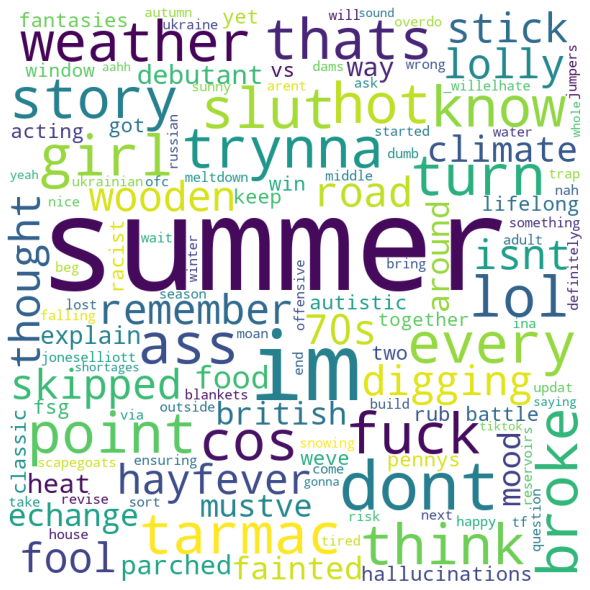

In [22]:
negative_sentences = ""
for sentence in df_dedup[df_dedup['sentiment'] == "Negative"]['Tweet'].tolist():
    negative_sentences = negative_sentences + " "+sentence
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_sentences)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

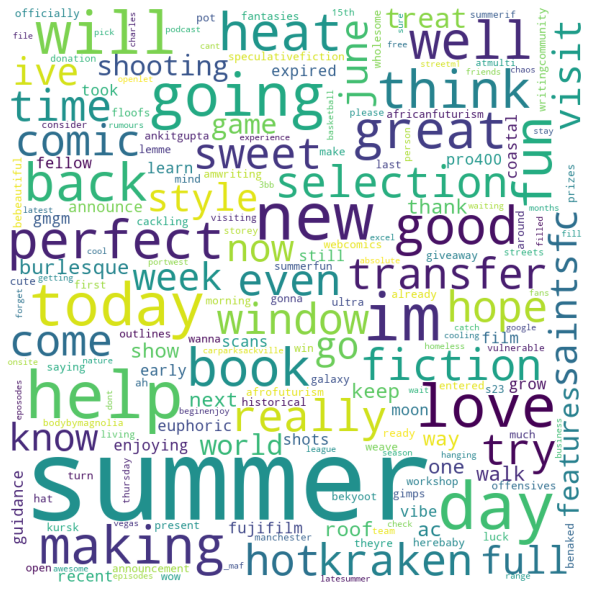

In [23]:
positive_sentences = ""
for sentence in df_dedup[df_dedup['sentiment'] == "Positive"]['Tweet'].tolist():
    positive_sentences = positive_sentences + " "+sentence
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_sentences)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()